# Temperature and flow solutions

In [30]:
%load_ext autoreload
%autoreload 2
#%run ct_data.py '../crunchtope_model/results.nc' -c pH totcon
%run pf_data.py '../pflo_revisions/hydrothermal.h5'
%run figures.py
import cmcrameri.cm as cm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Primary minerals: ['Anorthite', 'Albite', 'Diopside', 'Hedenbergite', 'Forsterite', 'Fayalite']
Secondary minerals: ['Tremolite', 'Prehnite', 'Talc', 'Quartz', 'Saponite_Mg', 'Zoisite', 'Chamosite', 'Clinochlore', 'Analcime', 'Anhydrite', 'Calcite', 'Annite']
Primary mineral groups: {'olivine': ['Forsterite', 'Fayalite'], 'clinopyroxenes': ['Diopside', 'Hedenbergite'], 'plagioclases': ['Anorthite', 'Albite']}
Secondary mineral groups: {'clays': ['Saponite_Mg', 'Chamosite', 'Clinochlore'], 'zeolites': ['Analcime'], 'amphiboles': ['Tremolite'], 'inosilicates': ['Prehnite'], 'talc': ['Talc'], 'epidotes': ['Zoisite'], 'sulfates': ['Anhydrite'], 'carbonates': ['Calcite'], 'quartz': ['Quartz'], 'mica': ['Annite']}


Text(0, 0.5, 'Z / m')

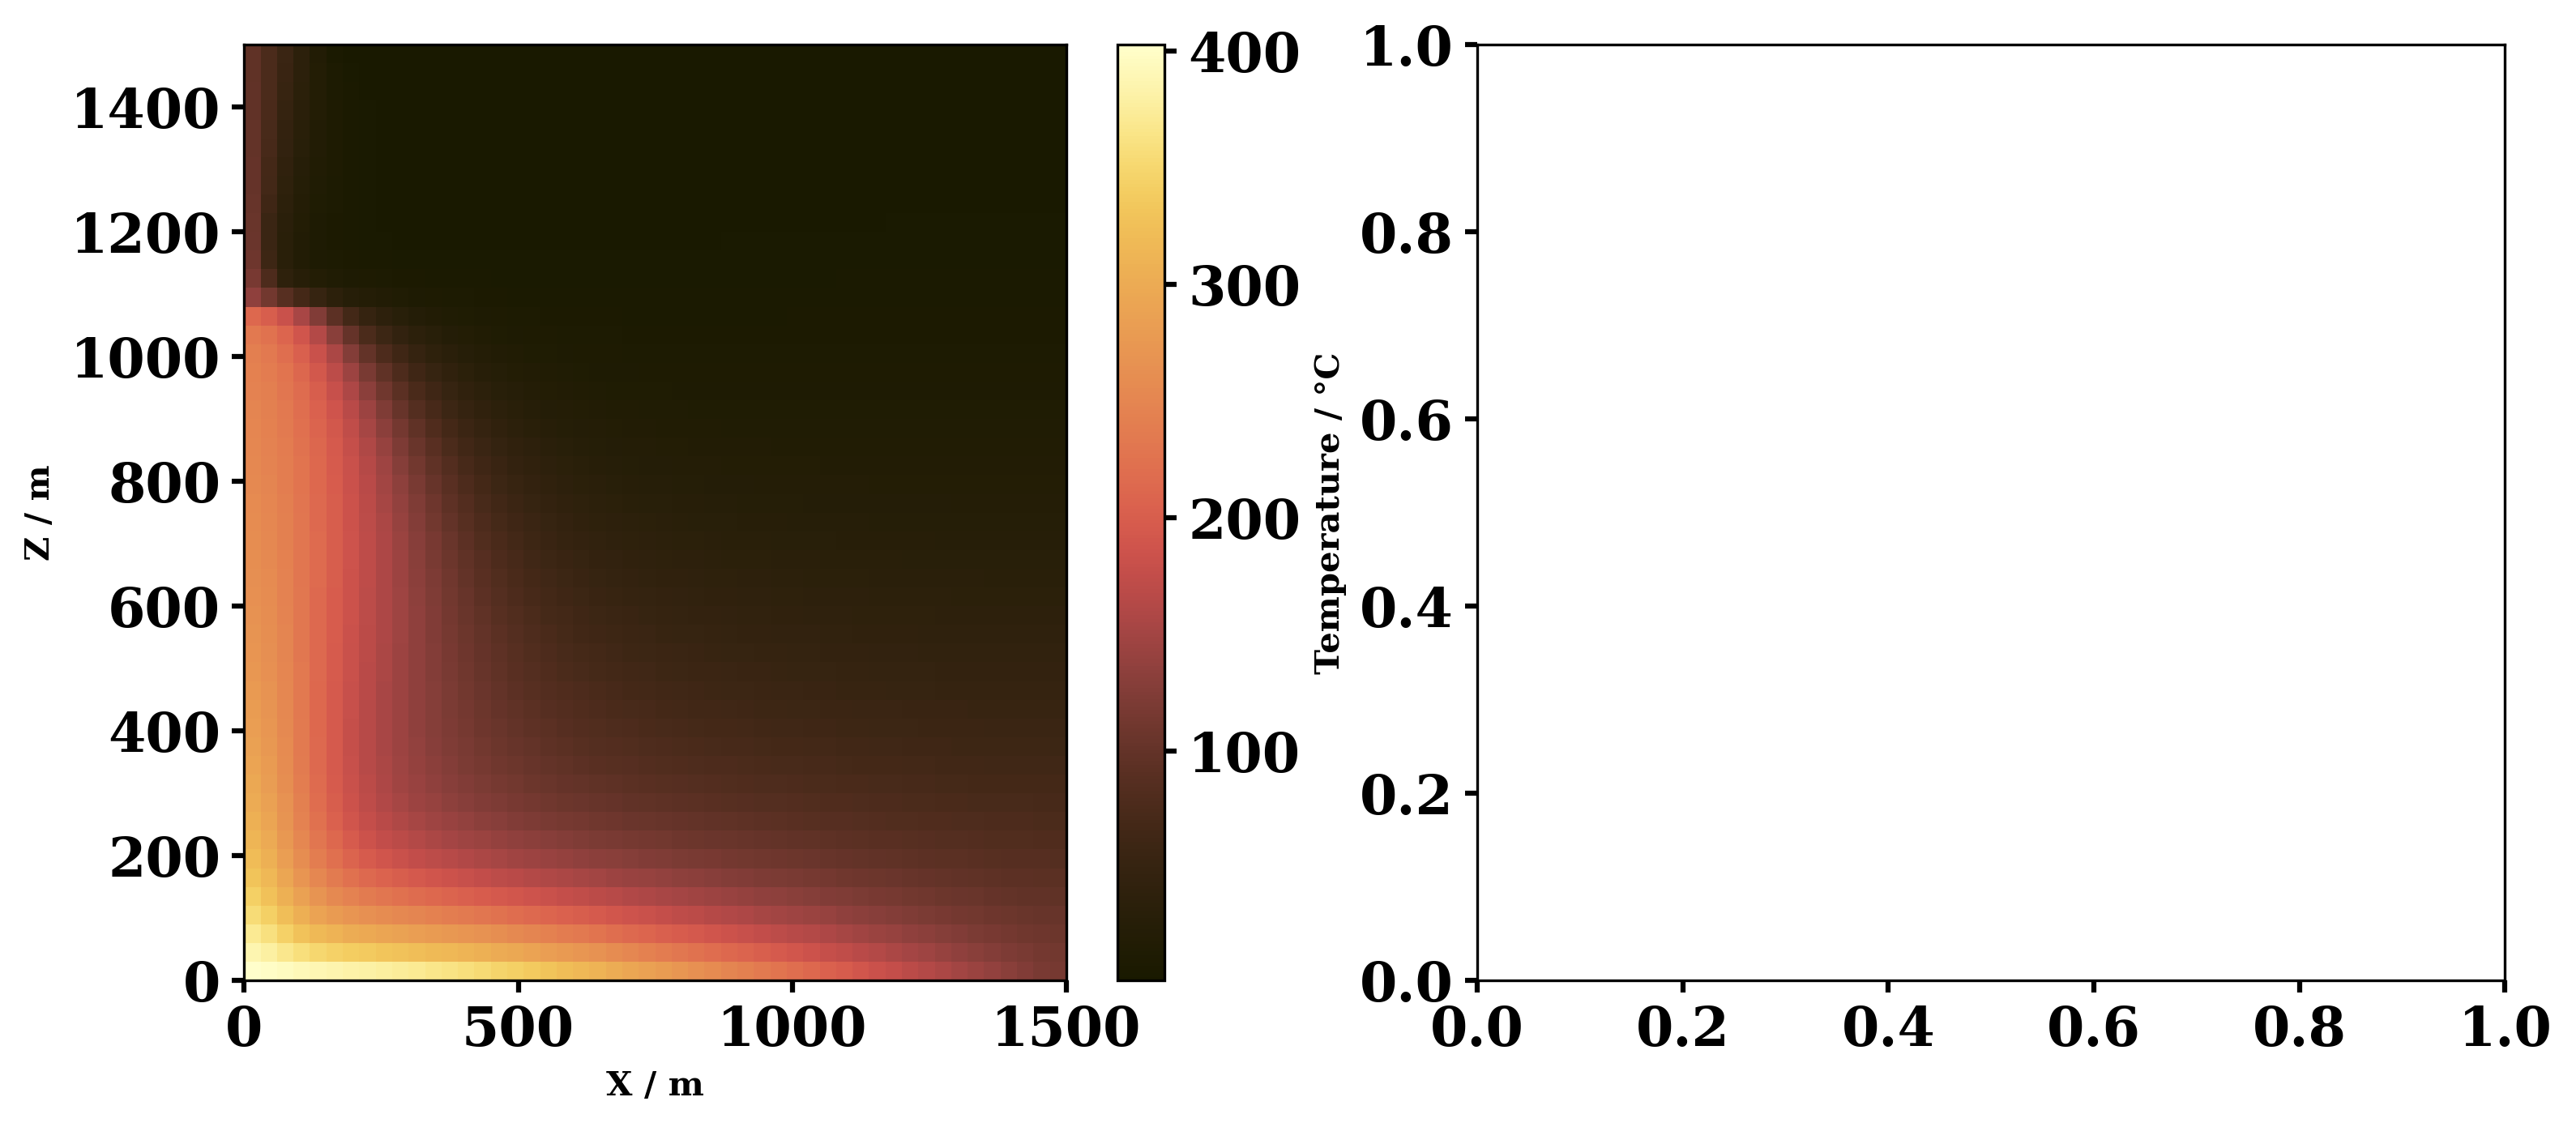

In [31]:
import matplotlib.pyplot as plt
plt.style.use('custom.mplstyle')
import xarray as xr

ds = pf_data

# Assuming 'ds' is your xarray dataset and 'temperature' is the variable of interest
# Replace 'ds' with the actual dataset name
temperature = ds.Temperature.isel(y=0, time=-1).T

# Extract X and Z spatial coordinates
x = ds.coords['x']  # Replace 'X' with actual x-coordinate name if different
z = ds.coords['z']  # Replace 'Z' with actual z-coordinate name if different

# Create the contour plot
fig, ax = plt.subplots(1,2, figsize=(12, 5))
contour = ax[0].pcolormesh(x, z, temperature, cmap=cm.lajolla)

# Add color bar for temperature
fig.colorbar(contour, label='Temperature / °C')

# Label axes
ax[0].set_xlabel('X / m')
ax[0].set_ylabel('Z / m')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Select the velocity slices at y=0 and for the nearest time step at time=1000
x_velocity_slice = ds['Liquid X-Velocity'].isel(y=0).sel(time=1000, method='nearest').values
z_velocity_slice = ds['Liquid Z-Velocity'].isel(y=0).sel(time=1000, method='nearest').values

speed = np.sqrt(x_velocity_slice**2 + z_velocity_slice**2)

# Extract X and Z coordinates
x = ds.coords['x'].values  # 1D X array
z = ds.coords['z'].values  # 1D Z array

x_velocity_slice = x_velocity_slice.T  # Transpose to match (Z, X)
z_velocity_slice = z_velocity_slice.T  # Transpose to match (Z, X)
permeability = np.log10(pf_data['Permeability'].isel(y=0).sel(time=1000, method='nearest').values.T)

# Create meshgrid from X and Z coordinates
X, Z = np.meshgrid(x, z)

# Create the stream plot for X and Z velocities
strm = ax[1].streamplot(X, Z, u=x_velocity_slice, v=z_velocity_slice, density=2, color='w', linewidth=0.5, arrowsize=1, arrowstyle='->')

from matplotlib.colors import BoundaryNorm
cmap = plt.get_cmap('viridis')
levels = [-15.69897, -14.69897, -13.69897, -12.69897]
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

# Use pcolormesh for sharp, blocky rendering
cmap = plt.get_cmap(cm.batlow)
norm = plt.Normalize(vmin=min(levels), vmax=max(levels))

# Plot with pcolormesh
mesh = ax[1].pcolormesh(X, Z, permeability, cmap=cmap, norm=norm)

# Label the axesaa
ax[1].set_xlabel('X / m')
ax[1].set_ylabel('Z / m')
cbar = fig.colorbar(mesh, label = 'Permeability / log$_10$(m$^2$)')

# Get the current y-ticks
y_ticks = [100, 300, 500, 700, 900, 1100, 1300, 1500]

# Add capital letter labels to the subplots
for i, axis in enumerate(ax):
    import string
    if i == 0:
        c = 'w'
    else:
        c = 'k'
    axis.text(0.93, 0.99, string.ascii_uppercase[i], transform=axis.transAxes,
              fontsize=16, fontweight='bold', va='top', c=c)
    # Set the y-ticks with reversed labels
    ax[i].set_yticklabels(y_ticks[::-1])

ax[1].text(0.25, 0.9, "Pillow Basalts", transform=axis.transAxes,
            fontsize=16, fontweight='bold', va='top', c=c)
ax[1].text(0.25, 0.4, "Sheeted Dykes", transform=axis.transAxes,
            fontsize=16, fontweight='bold', va='top', c=c)

# Adjust layout and save the figure
fig.tight_layout()
fig.savefig('output/figure_s1.png', dpi=300)

/tmp/ipykernel_23005/1443882142.py:54: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[i].set_yticklabels(y_ticks[::-1])


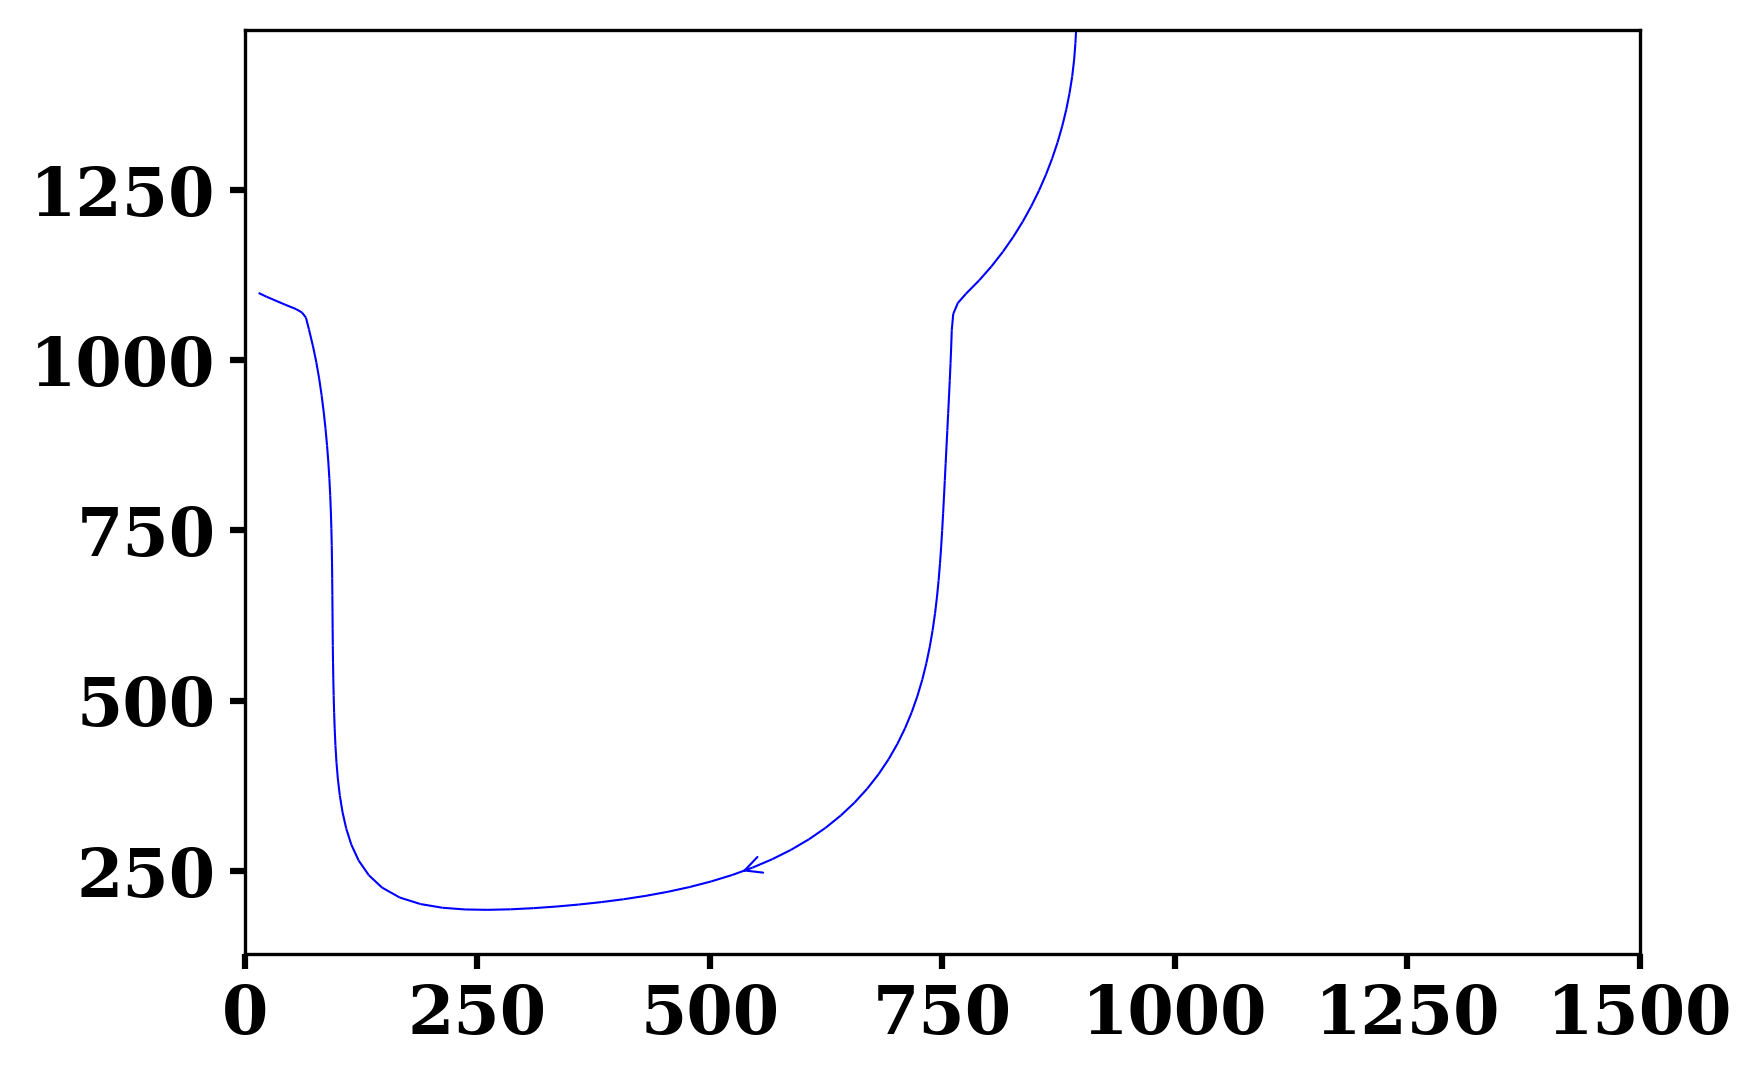

Total length of the streamline: 2653.12 units


28.814630011606713

In [33]:
# Function to calculate the average speed along a streamline
def average_speed_along_streamline(streamline_data):
    # Get the coordinates and velocities along the first streamline
    U = x_velocity_slice
    V = z_velocity_slice
    y=z
    
    x_coords = []
    y_coords = []
    # Extract x, y coordinates from the streamline
    for path in streamline_data.lines.get_paths():
        x_coords.append(path.vertices[0, 0])
        y_coords.append(path.vertices[0, 1])

    # Interpolate the velocity (U, V) and speed at these points
    interpolated_speeds = []
    for (x_val, y_val) in zip(x_coords, y_coords):
        u_val = np.interp(x_val, x, U[:, np.argmin(np.abs(y - y_val))])
        v_val = np.interp(y_val, y, V[np.argmin(np.abs(x - x_val)), :])
        interpolated_speeds.append(np.sqrt(u_val**2 + v_val**2))

    # Calculate the average speed along the streamline
    avg_speed = np.mean(interpolated_speeds) / 0.01
    return avg_speed

# Function to calculate the length of a streamline
def streamline_length(streamline_data):
    total_length = 0  # Initialize total length to 0

    # Loop through each streamline in the streamline data
    for path in streamline_data.lines.get_paths():
        # Extract x, y coordinates from the streamline vertices
        x_coords = path.vertices[:, 0]
        y_coords = path.vertices[:, 1]

        # Loop through the vertices and calculate the distance between consecutive points
        for i in range(1, len(x_coords)):
            x1, y1 = x_coords[i - 1], y_coords[i - 1]
            x2, y2 = x_coords[i], y_coords[i]

            # Calculate the distance between the two points
            distance = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

            # Add the distance to the total length
            total_length += distance

    return total_length

strm = plt.streamplot(X, Z, u=x_velocity_slice, v=z_velocity_slice, density=2, start_points=[[750,750]], color='b', linewidth=0.5, arrowsize=1, arrowstyle='->')

plt.xlim(0,1500)
#plt.ylim(0,1500)
plt.show()
# Example usage: calculate the length of streamlines from the streamplot result
streamline_data = strm  # This is your streamline data from plt.streamplot
length = streamline_length(streamline_data)
print(f"Total length of the streamline: {length:.2f} units")



average_speed_along_streamline(strm)